# TABLE OF CONTENTS
1. Introduction -  Projecting Retail Sales

2. Data: Preprocessing

3. Data: Exploratory Data Analysis / Visualizations
4. Modeling
- Objective 1: Predicting Quantity Sold Based on Price

    - Baseline Model Selection:

        - kNN Regression Model

        - Simple Linear Regression Model

        - Polynomial Regression Model

        - Decision Tree Regression Model

    - Model Training & Evaluation

- Objective 2: Predicting Annual Sales Cycles

    - Time Series Analysis: 

        - Augmented Dickey-Fuller Tests

        - Additive Decomposition

        - Autocorrelation / Partial Autocorrelation

        - Granger Causality Tests

    - Time Series Models:

        - AutoRegressive Model (AR)

        - Moving Average Model (MA)

        - ARMA/ARIMA Model
        
    - Revenue Forecasting
        
5. Results & Discussion

# 1. INTRODUCTION: PROJECTING RETAIL SALES

In a world where e-commerce is increasingly prevalent, it is crucial to optimize pricing strategies and supply chains to drive profitability in the retail industry. Our primary goal in this notebook is to leverage machine learning techniques to understand customer behavior and drive revenue growth. 

Our overall objective is to project retail sales by forecasting customer shopping behavior. We break this into two separate tasks to answer the following questions about sales and customer behavior:
1. How does the price of an item impact the quantity sold?
2. How can we predict annual sales cycles and trends?

All code in this report is organized according to the Table of Contents above. Appropriate visuals and explanations appear under each section.

A flow chart of our overall project and model development process is included below. It provides a visual illustration for the contents in this notebook, and may be useful for reference throughout the report.

![Image Description](CS109a_Final_Project_Flow_Chart.jpeg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
import warnings

Our code depends on the libraries and imported algorithms in the code cell above. These libraries include:

- numpy: This library allows us to work with arrays.

- pandas: This library allows us to analyze data. Namely, it includes data manipulation and analysis tools such as those that offer data structures and operations for manipulating numerical tables and time series. 

- matplotlib: This library allows us to create data visualizations, and supports many of the visualizations seen throughout this notebook.

- seaborn: This library also contains data visualization tools, and supports many of the visualizations seen throughout this notebook.

- sklearn: The scikit-learn library provides various unsupervised and supervised learning algorithms, and supports the models implemented throughout this notebook. DecisionTreeRegressor and LinearRegression, for instance, are provided by this library.

In [2]:
# Muting warnings
warnings.filterwarnings('ignore')

# 2. DATA: PREPROCESSING

Here, we conduct the necessary steps to prepare our data for modeling and visualizations. The dataset we are using is the Online Retail II dataset from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/502/online+retail+ii), which contains all the transactions occurring for a UK-based and registered, non-store online retailer between 01/12/2009 and 09/12/2011. We converted and combined both sheets of the dataset into a single .csv file using Microsoft Excel. There are 1,067,371 total recorded item transactions, each with the invoice number, stock code, item description, quantity ordered, invoice date, price, customer ID, and customer’s country. There are multiple rows for many invoices, as each row represents the order information for a single item type. In the given dataset, all variables are of an object data type except for Quantity, Price, and Customer ID. We want to treat Quantity and Price as quantitative variables, but will treat Customer ID into a categorical variable (the data type will be modified accordingly, as explained below). For Quantity and Price, we calculated descriptive statistics (mean, median, etc.) which we have used to identify outliers and otherwise examine the data, as explained in depth below.

In [3]:
# Used Microsoft Excel to turn the file from .xslx to .csv
df1 = pd.read_csv('online_retail_II_2009_2010.csv')
df2 = pd.read_csv('online_retail_II_2010_2011.csv')

# Concatenating the two sheets of data
df = pd.concat([df1, df2], ignore_index=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom


In [4]:
summary = df.describe()
summary = summary.drop('Customer ID', axis=1)
print(summary)

print('\ndata types:')
print(df.dtypes)

           Quantity         Price
count  1.067371e+06  1.067371e+06
mean   9.938898e+00  4.649388e+00
std    1.727058e+02  1.235531e+02
min   -8.099500e+04 -5.359436e+04
25%    1.000000e+00  1.250000e+00
50%    3.000000e+00  2.100000e+00
75%    1.000000e+01  4.150000e+00
max    8.099500e+04  3.897000e+04

data types:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


In [5]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

column_names_list = df.columns.tolist()
print("Column names:", column_names_list)

Number of rows: 1067371
Number of columns: 8
Column names: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


    MODIFYING DATA TYPES FOR MODELING

For our time series analysis, we want to ensure that the InvoiceDate variable is in the appropriate date-time format.

In [6]:
# Turning InvoiceDate from string format to date-time format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
# Extracting month and year from the data (while preserving InvoiceDate column)
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009


    DATA MISSINGNESS

There are missing attributes for some observations, though these should not be an issue since there is only missing data for the item Description and Customer ID columns (which are mainly irrelevant for our sales prediction purposes, as the observations with missing Description entries still have StockCode data). 

There are also negative sales volumes, which might be due to item returns. We account for these negative sales volumes by treating them as negative revenue (quantity * price), as it is important that we keep these negative data entries in our analysis.

In [8]:
n_rows_with_missingness = df.isna().any(axis=1).sum()
n_cols_with_missingness = df.isna().any().sum()
col_missingness = df.isna().sum()

print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 243007
# columns with missingness: 2

columns with missingness:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
Month               0
Year                0
dtype: int64


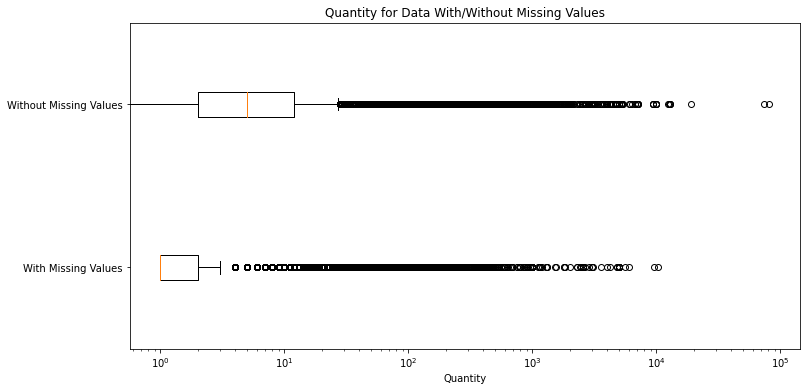

Statistics for With Missing Values:
 count    243007.000000
mean          1.540548
std          98.859370
min       -9600.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       10200.000000
Name: Quantity, dtype: float64 

Statistics for Without Missing Values:
 count    824364.000000
mean         12.414574
std         188.976099
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [9]:
with_missing = df[df.isna().any(axis=1)]['Quantity'].dropna()
without_missing = df[~df.isna().any(axis=1)]['Quantity'].dropna()

plt.figure(figsize=(12, 6))
plt.boxplot([with_missing, without_missing], labels=['With Missing Values', 'Without Missing Values'], vert=False)

plt.xscale('log') # Plotted on log scale for interpretability
plt.xlabel('Quantity')
plt.title('Quantity for Data With/Without Missing Values')
plt.show()

print("Statistics for With Missing Values:\n", with_missing.describe(), "\n")
print("Statistics for Without Missing Values:\n", without_missing.describe())

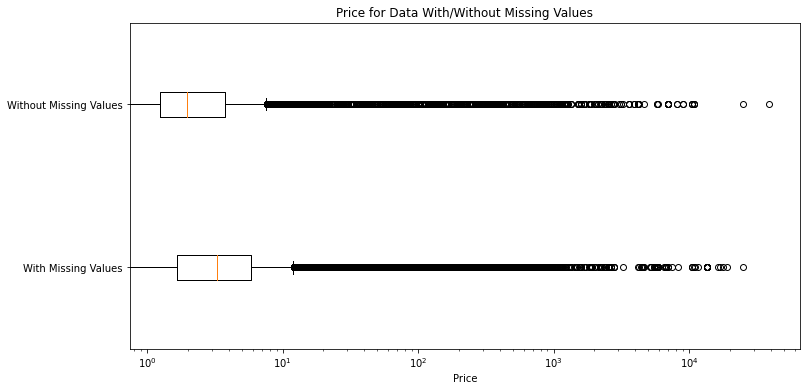

Statistics for With Missing Values:
 count    243007.000000
mean          7.948744
std         224.275451
min      -53594.360000
25%           1.660000
50%           3.290000
75%           5.790000
max       25111.090000
Name: Price, dtype: float64 

Statistics for Without Missing Values:
 count    824364.000000
mean          3.676800
std          70.241388
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: Price, dtype: float64


In [10]:
with_missing = df[df.isna().any(axis=1)]['Price'].dropna()
without_missing = df[~df.isna().any(axis=1)]['Price'].dropna()

plt.figure(figsize=(12, 6))
plt.boxplot([with_missing, without_missing], labels=['With Missing Values', 'Without Missing Values'], vert=False)

plt.xscale('log') # Plotted on log scale for interpretability
plt.xlabel('Price') 
plt.title('Price for Data With/Without Missing Values')
plt.show()

print("Statistics for With Missing Values:\n", with_missing.describe(), "\n")
print("Statistics for Without Missing Values:\n", without_missing.describe())

The missingness appears to slightly impact the quantities and prices of purchases made by the customers. In the quantity graph, the boxplot for the data without missing values is wider than and shifted to the right of that for the data with missing values. In the price graph, the boxplot for the data without missing values is shifted to the left of that for the data with missing values. However, there are many outliers for each boxplot, indicating that the relationship between missingness and quantity/price is not strong. This may not be an instance of missingness completely at random for our categorical variables of Description and Customer ID, but the impact here may be negligible.

We can impute empty strings for missing values. Missingness in the Description column is largely irrelevant since the complete StockCode conveys the same fundamental information about our items. We may want to use Customer ID to examine the likelihood of repeat customers. If Customer ID data is needed for these purposes, it would likely bias our predictions to impute existing IDs or to create new IDs for the missing values. Thus, we may drop observations with missing Customer IDs as needed. Note that we can analyze the diversity of a customer's item purchases (if they are only purchasing one type of item or multiple per purchase) using the complete Invoice ID data, so Customer ID is not important for analyzing individual purchase instances. 

In the event that we do not need Customer ID and Description at all, we simply drop these columns. 

    MODIFYING DATA TYPES FOR MODELING (CON.)

In this section, we implement the changes to Customer ID and Description as explained above.

In [11]:
# Turning Customer ID into a string data type and dropping the .0 at the end of each ID
# Checking for NaN values and replacing them with an empty string
df['Customer ID'] = df['Customer ID'].apply(lambda x: str(x).replace('.0', '') if pd.notna(x) else '')
df['Customer ID'] = df['Customer ID'].astype(str)
df['Customer ID'] = df['Customer ID'].str.replace(r'\.0$', '', regex=True)

# Imputing empty strings for missing Description entries
df['Description'] = df['Description'].fillna('')

In [12]:
# Checking that we no longer have any missingness
n_rows_with_missingness = df.isna().any(axis=1).sum()
n_cols_with_missingness = df.isna().any().sum()
col_missingness = df.isna().sum()

print('# rows with missingness:', n_rows_with_missingness)
print('# columns with missingness:', n_cols_with_missingness)
print(f'\ncolumns with missingness:\n{col_missingness}')

# rows with missingness: 0
# columns with missingness: 0

columns with missingness:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Month          0
Year           0
dtype: int64


    DATA SCALING

We do not need to scale our data since the only numerical variables are quantity and price (which we may treat together by creating a separate "Revenue" column). All other variables are treated categorically.

In [13]:
# Creating a Revenue column, which represents Quantity * Price for each item purchase observation
df['Revenue'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,2009,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,2009,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,2009,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,2009,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,2009,30.0


    DATA IMBALANCE

We do not have a problem with data imbalance since we are not dealing with a classification problem. The data set contains all transactions occurring for a UK-based and registered, non-store online retailer between 01/12/2009 and 09/12/2011, so there is no issue with missing/imbalanced samples.

    OUTLIER ANALYSIS

We see that there are many outliers when measured by item quantity, item price, and total revenue. Since our revenue outliers may be due to abnormally high sales quantities, item prices, or both, we have found the common outliers for revenue & quantity and revenue & price. We have also found the common outliers for price & quantity, which may be of particular interest to ensure that our overall predictions are not skewed by abnormal low quantity/price or high quantity/price combinations.

In [14]:
# Analyzing outliers in order quantity
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]
quantity_outliers = outliers['Invoice'].unique()
print('invoice IDs for quantity outliers:', quantity_outliers)
print('# of unique outlier orders:', len(quantity_outliers))

invoice IDs for quantity outliers: ['489434' '489435' '489436' ... '581584' '581585' '581586']
# of unique outlier orders: 29114


In [15]:
# Analyzing outliers in item price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
price_outliers = outliers['Invoice'].unique()
print('invoice IDs for price outliers:', price_outliers)
print('# of unique outlier orders:', len(price_outliers))

invoice IDs for price outliers: ['489437' '489439' '489444' ... '581580' '581586' '581587']
# of unique outlier orders: 21776


In [16]:
# Analyzing outliers in revenue (which may be due to high sales quantities, high item prices, or both)
Q1 = df['Revenue'].quantile(0.25)
Q3 = df['Revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Revenue'] < lower_bound) | (df['Revenue'] > upper_bound)]
revenue_outliers = outliers['Invoice'].unique()
print('invoice IDs for revenue outliers:', revenue_outliers)
print('# of unique outlier orders:', len(revenue_outliers))


invoice IDs for revenue outliers: ['489434' '489435' '489436' ... '581583' '581584' '581586']
# of unique outlier orders: 25557


In [17]:
# Cross-referencing which revenue outliers are likely due to high sales quantities or high item prices
quantity_outliers = set(quantity_outliers)
price_outliers = set(price_outliers)
revenue_outliers = set(revenue_outliers)

common_outliers_quantity_revenue = quantity_outliers.intersection(revenue_outliers)
print('# of common outliers for quantity and revenue:', len(common_outliers_quantity_revenue))

common_outliers_price_revenue = price_outliers.intersection(revenue_outliers)
print('# of common outliers for price and revenue:', len(common_outliers_price_revenue))

# of common outliers for quantity and revenue: 18740
# of common outliers for price and revenue: 12971


In [18]:
# Finding common quantity and price outliers
common_outliers_quantity_price = quantity_outliers.intersection(price_outliers)
print('# of common outliers for quantity and revenue:', len(common_outliers_quantity_price))


# of common outliers for quantity and revenue: 11687


    OTHER PROCESSING

In addition to the preprocessing steps already described, we created a BasketSize variable that adds together the total number of items in each order invoice. We then created a new dataframe with just invoices and corresponding basket sizes. We also created a dataframe that contains information for each Customer ID. Each customer ID is associated with a frequency (number of unique invoices), recency (most recent invoice), and monetary (total revenue flow from the customer) column. Note that the first row of this dataframe collects all of the data for the observations without customer IDs.

With these preprocessing steps, our data is ready for visualizing and modeling.

In [19]:
# Creating new category that adds together the total number of items in one order invoice
df['BasketSize'] = df.groupby('Invoice')['Quantity'].transform('sum')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Revenue,BasketSize
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,2009,83.4,166
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,2009,81.0,166
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,2009,81.0,166
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,2009,100.8,166
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,2009,30.0,166


In [20]:
# Creating a new dataframe with just invoices and basket sizes
basket_df = df[['Invoice', 'BasketSize']].drop_duplicates(subset='Invoice')
basket_df.head()

,Invoice,BasketSize
0,489434,166
8,489435,60
12,489436,193
31,489437,145
54,489438,826


In [21]:
# Creating a dataframe that contains information for each Customer ID
# Note that the first row of this dataframe will collect all of the data for the observations without customer IDs
customer = df.groupby('Customer ID').agg(Frequency=('Invoice', 'nunique'), 
                                          Recency=('InvoiceDate', 'max'), 
                                          Monetary=('Revenue', 'sum'))
customer.head()

,Frequency,Recency,Monetary
Customer ID,,,
,8752,2011-12-09 10:26:00,2638958.18
12346,17,2011-01-18 10:17:00,-64.68
12347,8,2011-12-07 15:52:00,5633.32
12348,5,2011-09-25 13:13:00,2019.40
12349,5,2011-11-21 09:51:00,4404.54


In [22]:
# Dropping the first row of the customer dataframe
customer = customer.iloc[1:]
customer.head()

,Frequency,Recency,Monetary
Customer ID,,,
12346,17,2011-01-18 10:17:00,-64.68
12347,8,2011-12-07 15:52:00,5633.32
12348,5,2011-09-25 13:13:00,2019.40
12349,5,2011-11-21 09:51:00,4404.54
12350,1,2011-02-02 16:01:00,334.40


# 3. DATA: EXPLORATORY DATA ANALYSIS / VISUALIZATIONS

Our objectives in our Exploratory Data Analysis process include a focus on the Quantity, InvoiceDate, and Price features of the data, since the other information is purely for customer/product identification purposes and thus may not be as relevant to predicting overall sales. To better understand how we can project sales, we examine the relationship between quantity and price, invoice date and sales (quantity sold, price of items), and other such relations. To provide more granularity on sales trends, we explore the specific item IDs for products bought in particularly high/low quantities or those bringing in particularly high/ low overall revenue.

In this section, we create a number of visualizations. 

1. Distribution Plots: We depict the spread of revenue, quantity, and price data to examine the presence of outliers and overall distribution of transaction behavior. These plots display high numbers of outliers, as discussed in the data exploration above.

2. Scatterplot between Quantity and Price: This plot displays a general negative correlation between price and quantity (as the price of an item increases, the quantity sold in a single transaction generally decreases). Though this holds on the "boundary" of the scatterplot, we also see that for items of lower prices, this relationship does not necessarily hold. A wide range of quantities are sold per transaction for cheaper items (for example, a customer may buy many units, as predicted by the boundary relationship, or very few), so there is effectively a "less than or equal to" relationship between item price and quantity sold.

3. Time Series Graphs: We illustrate the seasonality of certain products using introductory time series graphs. This informs the fact that there is a relationship between invoice date and demand (for certain items), which drives peaks in revenue (for instance, revenue tends to peak significantly between October and January in the years examined, implying unusually high demand for goods during the holiday season). Note that the sales trends of other items may also reflect changing aesthetic trends -- with the saliency of social media in today's marketing world, the life cycles of aesthetic trends are important in forecasting sales as well. We use more in-depth time series analysis to examine these trends going forward.

4. Violin Plot for Basket Size: The violin plots show high data density for basket sizes of 1000 items and below. Note that negative basket sizes are included to represent returns or other internal transactions. A relatively wide range of item quantities are purchased by customers, which may contribute to the outliers we see in quantity and revenue. Basket size data does not appear to convey any distinguishing characteristics for our model on its own, however.

5. Correlation Heatmap and Scatterplots for Individual Customer Characteristics: The correlation heatmap and scatterplot between customer transaction frequency and total revenue flow from that customer indicate a moderate positive correlation between the two variables. This confirms what we had expected: the more transactions a customer makes, the more revenue the business gains from that customer. The scatterplot of average transaction revenue and number of transactions per customer, however, shows that the number of transactions made by a customer does not strongly tell us any information about how much they spend per transaction, or vice versa. We cannot strongly predict whether someone will be a repeat customer based on how much they spend in a single transaction.

6. Count Plot for Customer Transaction Frequency: The count plot for customer transaction frequency allows us to examine the likelihood and magnitude of repeat customers. We see many one-time purchasers and many who return a few times within the 2 year time period the data covers. This conveys important information for forecasting sales, as customer retention plays a key role in the predictability and stability of total sales, and presents a possible avenue for further exploration in the future.

    DISTRIBUTION PLOTS

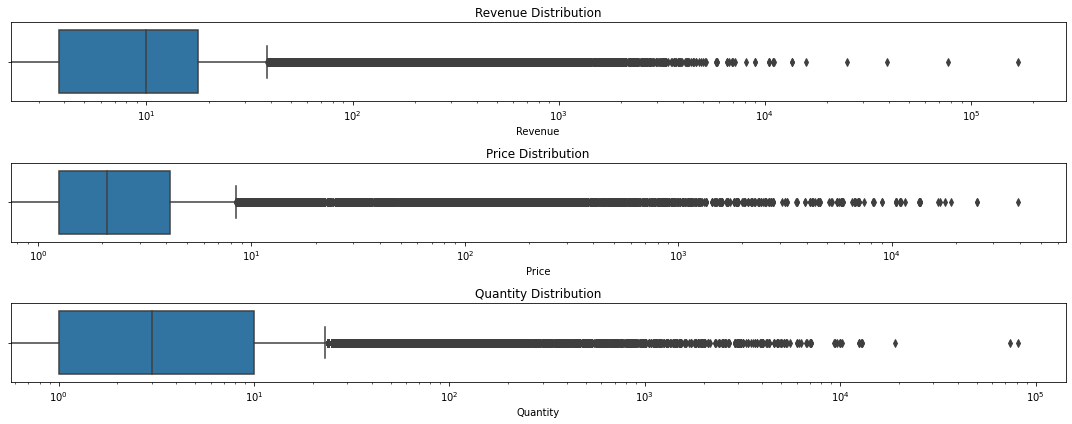

In [23]:
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1)
sns.boxplot(x='Revenue', data=df, orient='h')
plt.xscale('log')
plt.title('Revenue Distribution')

plt.subplot(3, 1, 2)
sns.boxplot(x='Price', data=df, orient='h')
plt.xscale('log')
plt.title('Price Distribution')

plt.subplot(3, 1, 3)
sns.boxplot(x='Quantity', data=df, orient='h')
plt.xscale('log')
plt.title('Quantity Distribution')

plt.tight_layout()
plt.show()

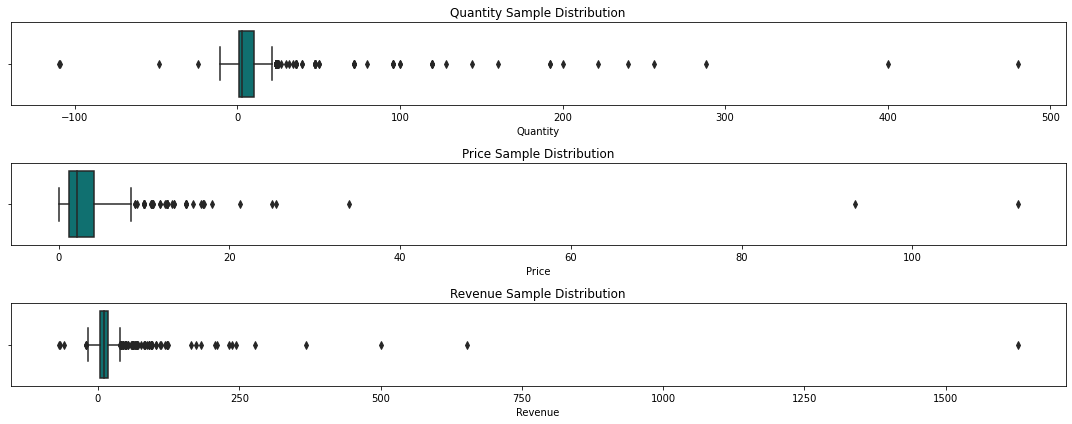

In [24]:
# Our boxplots above show a high quantity of outliers for each variable. Here, we create a random sample from our data and examine the boxplots for this sample. 

# Sample a subset of data (e.g., 1000 rows) for illustration
df_sample = df.sample(n=1000, random_state=0)

plt.figure(figsize=(15, 6))

# Quantity Plot
plt.subplot(3, 1, 1)
sns.boxplot(x=df_sample['Quantity'], color='teal')
plt.title('Quantity Sample Distribution')

# Price Plot
plt.subplot(3, 1, 2)
sns.boxplot(x=df_sample['Price'], color='teal')
plt.title('Price Sample Distribution')

# Revenue Plot
df_sample['Revenue'] = df_sample['Quantity'] * df_sample['Price']

plt.subplot(3, 1, 3)
sns.boxplot(x=df_sample['Revenue'], color='teal')
plt.title('Revenue Sample Distribution')

plt.tight_layout()
plt.show()

    RELATIONSHIP BETWEEN PRICE AND QUANTITY

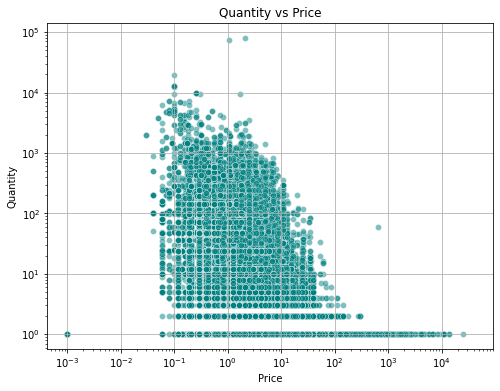

In [25]:
# Scatterplot between Price and Quantity
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Price', y='Quantity', data=df, color='teal', alpha=0.5)
plt.title('Quantity vs Price')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(True)

plt.show()

    TIME SERIES GRAPHS

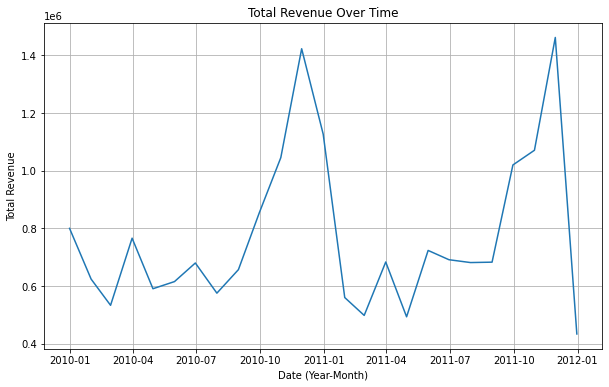

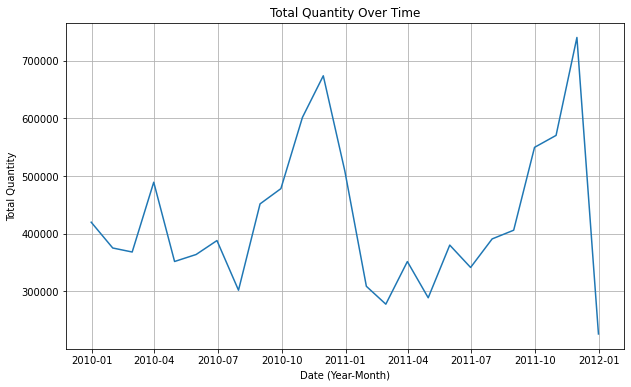

In [26]:
def total_by_month(var: str):
    total = df[[var, 'InvoiceDate']]
    monthly_totals = total.resample('M', on='InvoiceDate').sum()

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_totals.index, monthly_totals[var], label='Total ' + var)
    plt.title('Total '+ var + ' Over Time')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Total ' + var)
    plt.grid(True)
    plt.show()

# Time series graphs for total revenue and quantity over time
total_by_month('Revenue')
total_by_month('Quantity')


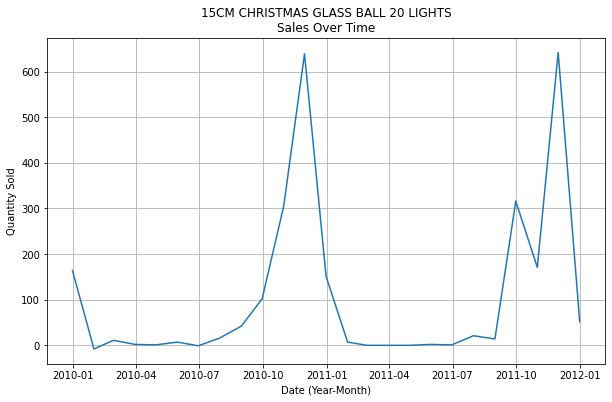

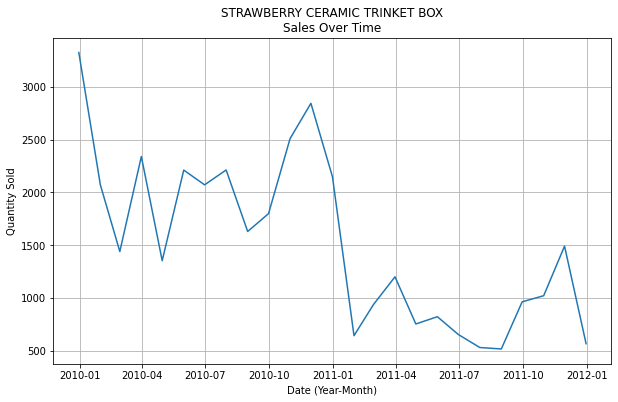

In [27]:
def prod_by_month(id: str, des: str):
    product = df[df['StockCode'] == id][['Quantity', 'InvoiceDate']]
    
    monthly_sales = product.resample('M', on='InvoiceDate').sum()

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_sales.index, monthly_sales['Quantity'], label=des)
    plt.title(f'{des}\nSales Over Time')
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Quantity Sold')
    plt.grid(True)
    plt.show()

# Time series graphs for sales over time of specific items
prod_by_month('85048', '15CM CHRISTMAS GLASS BALL 20 LIGHTS')
prod_by_month('21232', 'STRAWBERRY CERAMIC TRINKET BOX')

    BASKET SIZE VIOLIN PLOTS

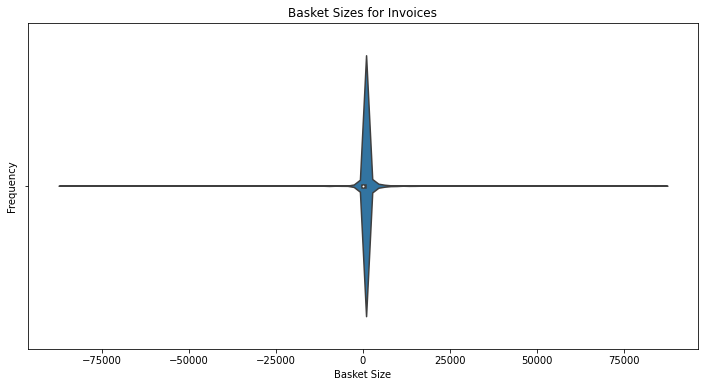

In [28]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='BasketSize', data=basket_df)
plt.xlabel('Basket Size')
plt.ylabel('Frequency')
plt.title('Basket Sizes for Invoices')
plt.show()

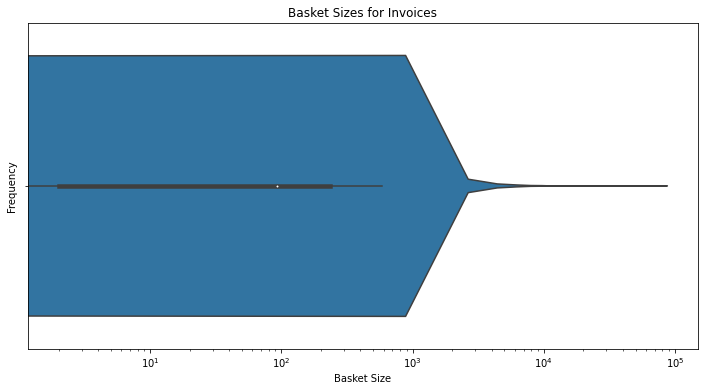

In [29]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='BasketSize', data=basket_df)
plt.xscale('log')
plt.xlabel('Basket Size')
plt.ylabel('Frequency')
plt.title('Basket Sizes for Invoices')
plt.show()

    CORRELATION HEATMAP AND SCATTERPLOTS FOR INDIVIDUAL CUSTOMER CHARACTERISTICS

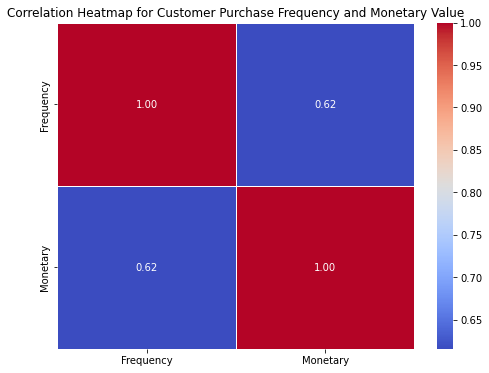

In [30]:
correlation_matrix = customer.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap for Customer Purchase Frequency and Monetary Value')
plt.show()

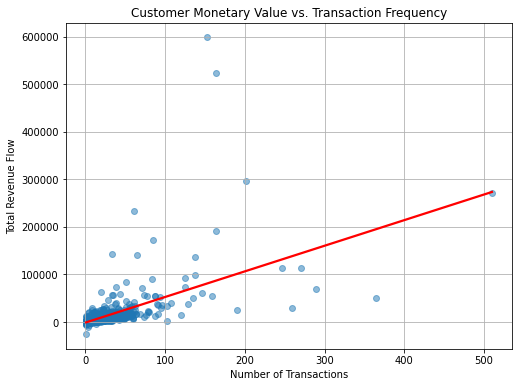

In [31]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Frequency', y='Monetary', data=customer, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ci=None)
plt.title(f'Customer Monetary Value vs. Transaction Frequency')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Revenue Flow')
plt.grid(True)
plt.show()

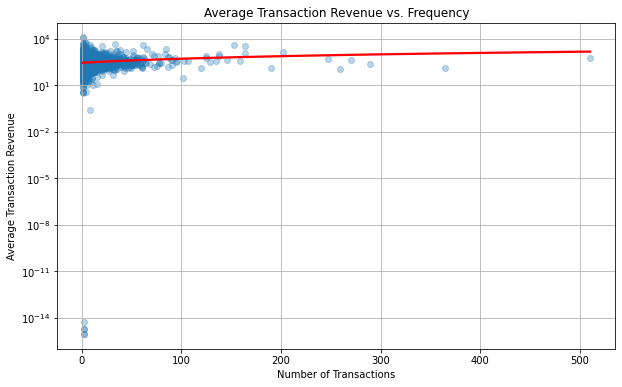

In [32]:
customer['AvgTransactionRevenue'] = customer['Monetary'] / customer['Frequency']

plt.figure(figsize=(10, 6))
sns.regplot(x='Frequency', y='AvgTransactionRevenue', data=customer, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'}, ci=None)

plt.title('Average Transaction Revenue vs. Frequency')
plt.xlabel('Number of Transactions')
plt.ylabel('Average Transaction Revenue')
plt.yscale('log')
plt.grid(True)

plt.show()

    COUNT PLOT FOR CUSTOMER TRANSACTION FREQUENCY

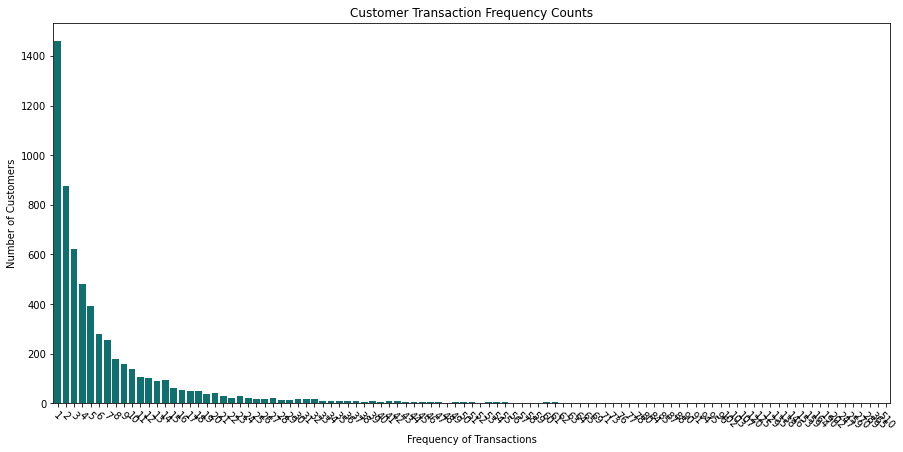

In [33]:
plt.figure(figsize=(15, 7))
sns.countplot(x='Frequency', data=customer, color='teal')
plt.title('Customer Transaction Frequency Counts')
plt.xlabel('Frequency of Transactions')
plt.ylabel('Number of Customers')
plt.xticks(rotation=-45)
plt.show()

# 4. MODELING

We analyze various aspects of retail sales using different models, as guided by our primary objectives.

1. Predicting Quantities Sold Based on Price: This is a helpful metric for a business to determine how much of an item they should keep in inventory. 

2. Time Series Analysis: As we have seen, sales appear to be cyclical for certain items, driving seasonal trends in revenue. Analyzing these yearly trends will help with accurate sales forecasts by month.

MODELING FOR OBJECTIVE 1: PREDICTING QUANTITIES SOLD BASED ON PRICE

<u>Baseline Model Selection</u>: Below, we run preliminary evaluations of kNN, simple linear, polynomial, and decision tree regression models to determine an optimal baseline model for Objective 1 (Predicting Quantities Sold Based on Price). We find significant limitations to the kNN and simple linear models, even after removing outliers from our data. Further examination of residual plots indicates that our data, as is, does not seem to satisfy the assumptions demanded by a linear model (the variance of the residuals shows a clear pattern, rather than being constant over all quantity levels). As reflected in the test MSE and R-squared scores for the models, the polynomial and decision tree regression models are certainly not perfect, but they do perform better. We thus select these as our basic models, and turn to tuning these models for more accurate predictions.


    KNN REGRESSION MODELS
    

In [34]:
# Splitting the dataset into a train and test set with 75% training data, 25% testing data.
X = df['Quantity'].values.reshape(-1,1)
y = df['Price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=109)

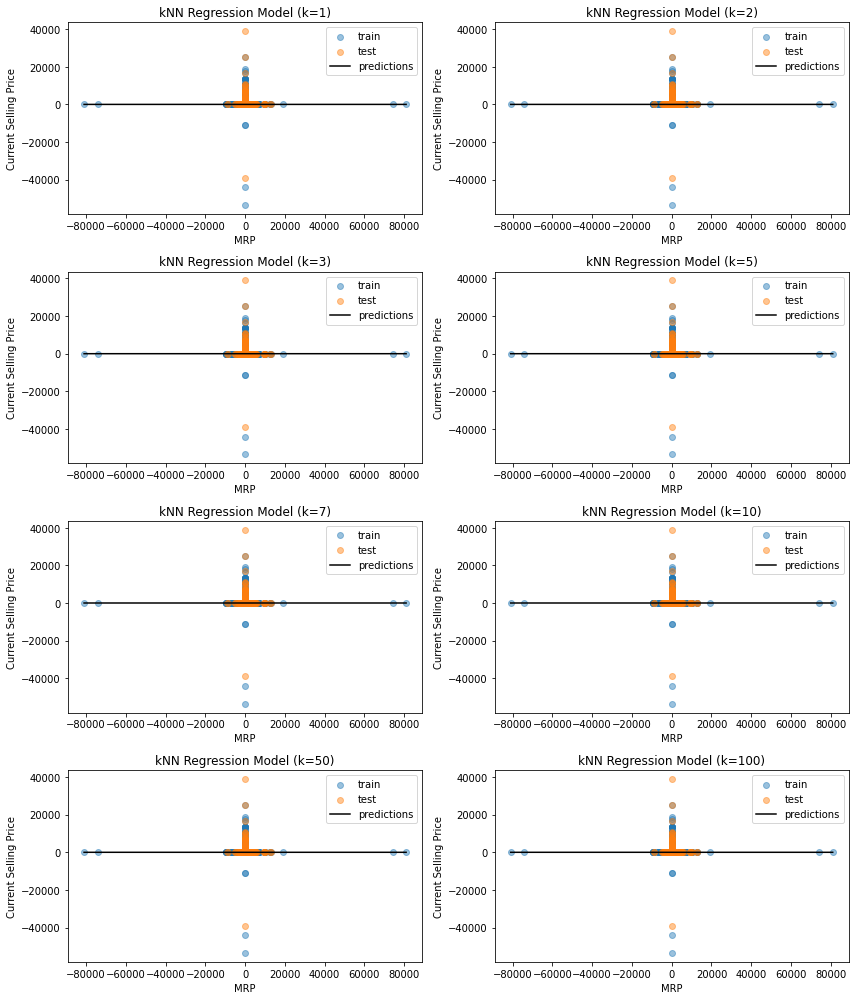

In [35]:
x_lin = np.linspace(df['Quantity'].min(), df['Quantity'].max(), 1000)
x_lin = pd.DataFrame(x_lin, columns=['Quantity'])

ks = [1,2,3,5,7,10,50,100]
all_preds = []
for k in ks:
    preds = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train).predict(x_lin)
    all_preds.append(preds)

fig, axs = plt.subplots(4,2, figsize=(12, 14))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for k, cur_preds, ax in zip(ks, all_preds, axs):
    ax.scatter(X_train, y_train, alpha=0.45, label='train')
    ax.scatter(X_test, y_test, alpha=0.45, label='test')
    ax.plot(x_lin, cur_preds, c='k', label='predictions')
    ax.set_xlabel('MRP')
    ax.set_ylabel('Current Selling Price')
    ax.set_title(f'kNN Regression Model (k={k})')
    ax.legend()
    
plt.tight_layout()

In [36]:
train_mses = []
test_mses = []

for k in ks:
    cur_knn = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    train_mses.append(mean_squared_error(y_train, cur_knn.predict(X_train)))
    test_mses.append(mean_squared_error(y_test, cur_knn.predict(X_test)))

best_idx = np.argmin(test_mses)
best_k = ks[best_idx]

In [37]:
best_mse = np.min(test_mses)
best_knn = KNeighborsRegressor(n_neighbors=best_k).fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

best_r2 = r2_score(y_test, y_pred)

In [38]:
print(
      f"The R-squared score evaluated on the test set for the best model "
      f"with k={best_k} and the lowest test MSE of {best_mse:.3f} is {best_r2:.4f}."
 )

The R-squared score evaluated on the test set for the best model with k=50 and the lowest test MSE of 19046.647 is 0.0040.


    SIMPLE LINEAR REGRESSION MODEL

In [39]:
linreg = LinearRegression().fit(X_train, y_train)

#Compute the MSE of the model
y_pred_train = linreg.predict(X_train)
lin_train_mse = mean_squared_error(y_train, y_pred_train)

y_pred_test = linreg.predict(X_test)
lin_test_mse = mean_squared_error(y_test, y_pred_test)

#Compute the R-squared of the model
lin_test_r2 = r2_score(y_test, y_pred_test)

In [40]:
print("Linear regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        lin_train_mse,
        lin_test_mse,
    )
)

print(f"\tTest R-squared\t{lin_test_r2:.4f}")

Linear regression model results:

	Train MSE	13979.6174
	Test MSE	19122.4200

	Test R-squared	0.0000


Text(0.5, 0, 'Quantity')

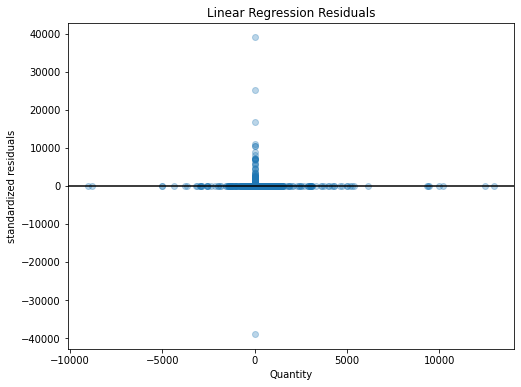

In [41]:
residuals = y_test - y_pred_test

plt.figure(figsize=(8, 6))
plt.scatter(X_test, residuals, alpha=0.3)
plt.axhline(0, c='k')
plt.ylabel('standardized residuals')
plt.title('Linear Regression Residuals')
plt.xlabel('Quantity')

We see that a linear regression model isn't quite appropriate for our given dataset, nor is a kNN model the best fit. However, this may be due to the high quantity of outliers in the Quantity and Price data. We remove these and see if the linear regression model is more applicable.

In [42]:
# Calculate the IQR for 'Price' and 'Quantity'
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

Q1_quantity = df['Quantity'].quantile(0.25)
Q3_quantity = df['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity

IQR_multiplier = 1.5

# Create boolean masks for outliers
outliers_price = (df['Price'] < Q1_price - IQR_multiplier * IQR_price) | (df['Price'] > Q3_price + IQR_multiplier * IQR_price)
outliers_quantity = (df['Quantity'] < Q1_quantity - IQR_multiplier * IQR_quantity) | (df['Quantity'] > Q3_quantity + IQR_multiplier * IQR_quantity)

# Create a new dataframe with outliers filtered out
df_no_outliers = df[~(outliers_price | outliers_quantity)]

# Display the shape of the original and filtered DataFrames
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)


Original DataFrame shape: (1067371, 12)
DataFrame shape after removing outliers: (883462, 12)


In [43]:
# Splitting the outlier-free dataset into a train and test set with 75% training data, 25% testing data.
X_no = df_no_outliers['Quantity'].values.reshape(-1,1)
y_no = df_no_outliers['Price'].values
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no, y_no, test_size=.25, random_state=109)

In [44]:
linreg_no = LinearRegression().fit(X_train_no, y_train_no)

#Compute the MSE of the model
y_pred_train_no = linreg_no.predict(X_train_no)
lin_train_mse_no = mean_squared_error(y_train_no, y_pred_train_no)

y_pred_test_no = linreg.predict(X_test_no)
lin_test_mse_no = mean_squared_error(y_test_no, y_pred_test_no)

#Compute the R-squared score of the model
lin_test_r2_no = r2_score(y_test_no, y_pred_test_no)

In [45]:
print("Linear regression model (no outlier) results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        lin_train_mse_no,
        lin_test_mse_no,
    )
)

print(f"\tTest R-squared\t{lin_test_r2_no:.4f}")

Linear regression model (no outlier) results:

	Train MSE	3.8147
	Test MSE	7.4399

	Test R-squared	-0.7804


Text(0.5, 0, 'Quantity')

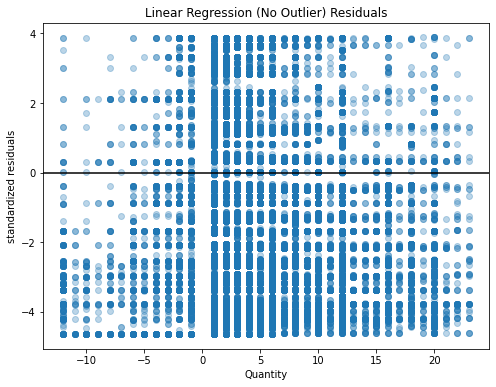

In [46]:
residuals_no = y_test_no - y_pred_test_no

plt.figure(figsize=(8, 6))
plt.scatter(X_test_no, residuals_no, alpha=0.3)
plt.axhline(0, c='k')
plt.ylabel('standardized residuals')
plt.title('Linear Regression (No Outlier) Residuals')
plt.xlabel('Quantity')

    POLYNOMIAL REGRESSION MODEL

In [47]:
# Splitting the dataset into a train and validation set with 80% training data, 20% testing data.
X_train80, X_val, y_train80, y_val = train_test_split(X_train_no, y_train_no, test_size=.2, random_state=1)

In [48]:
def find_mse(model, x_poly_train, y_train, x_poly_test, y_test):
    y_pred_train = model.predict(x_poly_train)
    y_pred_test = model.predict(x_poly_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    return train_mse, test_mse

In [49]:
poly_train_mses = []
poly_val_mses = []
degrees = range(1, 31)
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, interaction_only=False, include_bias=False)
    x_poly_train80 = poly.fit_transform(X_train80)
    x_poly_val = poly.transform(X_val)

    linreg.fit(x_poly_train80, y_train80)
    train_mse, val_mse = find_mse(linreg, x_poly_train80, y_train80, x_poly_val, y_val)
    poly_train_mses.append(train_mse)
    poly_val_mses.append(val_mse)

best_degree = degrees[poly_val_mses.index(min(poly_val_mses))]
print(f"The degree with the lowest validation error is {best_degree}.")

The degree with the lowest validation error is 12.


In [50]:
poly = PolynomialFeatures(degree=best_degree, interaction_only=False, include_bias=False)
X_poly_train_complete = poly.fit_transform(X_train_no)
X_poly_test_complete = poly.transform(X_test_no)

linreg = LinearRegression()
linreg.fit(X_poly_train_complete, y_train_no)

y_pred_train_complete = linreg.predict(X_poly_train_complete)
y_pred_test_complete = linreg.predict(X_poly_test_complete)

# Compute the mean squared errors
train_mse_complete, test_mse_complete = find_mse(linreg, X_poly_train_complete, y_train_no, X_poly_test_complete, y_test_no)

#Compute the R-squared of the model
poly_train_r2 = r2_score(y_train_no, y_pred_train_complete)
poly_test_r2 = r2_score(y_test_no, y_pred_test_complete)

In [51]:
print("Polynomial regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_complete,
        test_mse_complete,
    )
)

print(f"\tTest R-squared\t{poly_test_r2:.4f}")

Polynomial regression model results:

	Train MSE	3.7364
	Test MSE	3.7514

	Test R-squared	0.1023


    DECISION TREE REGRESSION MODEL

In [52]:
poly = PolynomialFeatures(degree=best_degree, interaction_only=False, include_bias=False)
X_poly_train = poly.fit_transform(X_train_no)
X_poly_test = poly.transform(X_test_no)

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_poly_train, y_train_no)

y_pred_train_tree = tree_reg.predict(X_poly_train)
y_pred_test_tree = tree_reg.predict(X_poly_test)

# Compute the mean squared errors
train_mse_tree = mean_squared_error(y_train_no, y_pred_train_tree)
test_mse_tree = mean_squared_error(y_test_no, y_pred_test_tree)

# Compute the R-squared of the model
tree_train_r2 = r2_score(y_train_no, y_pred_train_tree)
tree_test_r2 = r2_score(y_test_no, y_pred_test_tree)

In [53]:
print("Decision tree regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_tree,
        test_mse_tree,
    )
)

print(f"\tTest R-squared\t{tree_test_r2:.4f}")

Decision tree regression model results:

	Train MSE	3.7123
	Test MSE	3.7269

	Test R-squared	0.1081



<u>Model Training & Evaluation</u>: Based on our data analysis and preliminary models above, we delve deeper into our polynomial and decision tree models here.

For our goal of predicting quantities sold based on price, we found that the baseline polynomial regression and decision tree regression models performed better than the kNN and linear regression models, having better test MSE and test R-squared scores. Below, we build on the baseline polynomial regression model by performing k-fold cross-validation and LASSO regularization. We build on the baseline decision tree regression model by performing GridSearch cross-validation and AdaBoost. 

    POLYNOMIAL REGRESSION MODEL TUNING

Our baseline polynomial regression model from above had a test MSE of 3.7514 and test R-squared score of 0.1023. The degree selected as the "best degree" on a single validation set was 12, yielding these results. In this section, we implement k-fold cross-validation to evaluate the robustness of this baseline model, and we implement LASSO regularization (which is intended to combat overfitting by prioritizing only the most important degree coefficients).

- k-fold Cross-Validation: We perform k-fold cross-validation with k = 10 for each polynomial regression from degree 1 to 30. Based on our mean train and validation MSE scores for each degree polynomial regression (displayed in the graph below), we found our best model to be that of degree 12. Above a degree of 15, the models show a clear decline in performance, though the train and validation MSEs for each degree polynomial model remained quite similar, indicating a consistent amount of generalizability across all models. The result of our "best degree" k-fold cross-validation model is thus the same as our earlier preliminary polynomial regression model. These results reinforce that it may be quite difficult to model or predict the relationship between quantity sold and price, as the train and test MSE scores remain quite high (>3.7). 

- LASSO Regularization: We aim to improve model consistency and performance using LASSO regularization, which will select for a set of significant polynomial degrees and thereby combat overfitting. Here, we have tested various alpha hyperparameter values, finding a best alpha of 0.0001. This alpha value yields the lowest mean cross-validation MSE of 3.739. We have plotted the mean validation MSE values for each regularization parameter alpha value, identifying the best alpha below. Another plot displays the values of each coefficient in the LASSO model using the best alpha value, giving us an idea of which coefficients may be significant (for instance, coefficients 1 and 2, which have large values). We will use our best alpha value to find the "most significant" set of polynomial degrees by using bootstraps. The results of this are trivial, so we do not proceed any further with creating a regularized model.

K-FOLD CROSS-VALIDATION

In [54]:
# k-fold cross-validation with k=10 for polynomial regression models
k = 10
train_mses_mean = []
val_mses_mean = []
val_mses_std = []

for degree in range(1, 31):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train_no)
    
    linreg = LinearRegression()  
    scores = cross_validate(linreg, X_poly_train, y_train_no, cv=k, scoring='neg_mean_squared_error', return_train_score=True, return_estimator=True)
    
    train_mse_mean = -np.mean(scores['train_score'])
    val_mse_mean = -np.mean(scores['test_score'])
    val_mse_std = np.std(scores['test_score'])

    train_mses_mean.append(train_mse_mean)
    val_mses_mean.append(val_mse_mean)
    val_mses_std.append(val_mse_std)

Best Model - Degree: 12, Train MSE: 3.7363645199867803, Validation MSE: 3.736513082885204


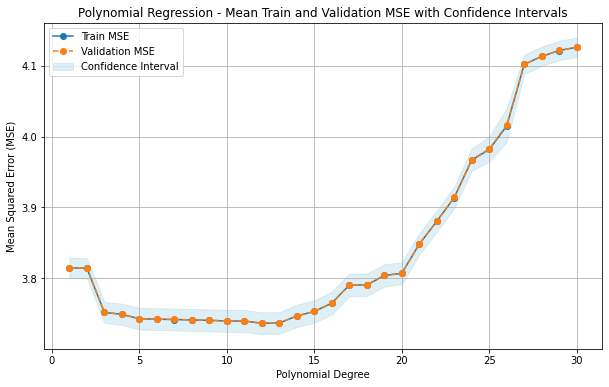

In [55]:
# Mean train and validation MSE plot for each degree polynomial regression
degrees = np.arange(1, 31)

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_mses_mean, label='Train MSE', marker='o', linestyle='-')
plt.plot(degrees, val_mses_mean, label='Validation MSE', marker='o', linestyle='--')

upper_bound = np.array(val_mses_mean) + np.array(val_mses_std)
lower_bound = np.array(val_mses_mean) - np.array(val_mses_std)

plt.fill_between(degrees, lower_bound, upper_bound, alpha=0.4, color='lightblue', label='Confidence Interval')

best_degree_cv = degrees[np.argmin(val_mses_mean)]
best_val_mse = min(val_mses_mean)
best_train_mse = train_mses_mean[best_degree_cv - 1]

print(f"Best Model - Degree: {best_degree_cv}, Train MSE: {best_train_mse}, Validation MSE: {best_val_mse}")

plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

plt.title('Polynomial Regression - Mean Train and Validation MSE with Confidence Intervals')
plt.grid(True)
plt.show()

In [56]:
poly_cv = PolynomialFeatures(degree=best_degree_cv, interaction_only=False, include_bias=False)
X_poly_train_cv = poly_cv.fit_transform(X_train_no)
X_poly_test_cv = poly_cv.transform(X_test_no)

linreg = LinearRegression()
linreg.fit(X_poly_train_cv, y_train_no)

y_pred_train_cv = linreg.predict(X_poly_train_cv)
y_pred_test_cv = linreg.predict(X_poly_test_cv)

# Computing the mean squared errors
train_mse_cv, test_mse_cv = find_mse(linreg, X_poly_train_cv, y_train_no, X_poly_test_cv, y_test_no)

#Computing the R-squared of the model
poly_train_r2_cv = r2_score(y_train_no, y_pred_train_cv)
poly_test_r2_cv = r2_score(y_test_no, y_pred_test_cv)

In [57]:
print("Polynomial regression model (k-fold cross-validation) results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_cv,
        test_mse_cv,
    )
)

print(f"\tTest R-squared\t{poly_test_r2_cv:.4f}")

Polynomial regression model (k-fold cross-validation) results:

	Train MSE	3.7364
	Test MSE	3.7514

	Test R-squared	0.1023


LASSO REGULARIZATION

In [58]:
# LASSO regularization 
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k=10

lasso = LassoCV(alphas=alphas, cv=k, max_iter=100000, fit_intercept=True)
poly = PolynomialFeatures(degree=30, interaction_only=False, include_bias=False)
x_poly_train_lasso = poly.fit_transform(X_train_no)

lasso.fit(x_poly_train_lasso, y_train_no)

# Storing the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso.mse_path_.mean(axis=1)

# Saving the best alpha based on the mean cross-validation MSE
best_alpha = lasso.alpha_

print(f"Best alpha: {best_alpha}")
print("Mean cross-validation MSEs for each alpha:")
for alpha, mse in zip(lasso.alphas_, lassoCV_val_mses_mean):
    print(f"Alpha: {alpha}, Mean CV MSE: {mse}")

Best alpha: 1e-05
Mean cross-validation MSEs for each alpha:
Alpha: 0.1, Mean CV MSE: 3.7400621800343314
Alpha: 0.01, Mean CV MSE: 3.7395722661425976
Alpha: 0.001, Mean CV MSE: 3.739230821075336
Alpha: 0.0001, Mean CV MSE: 3.7391203805716238
Alpha: 1e-05, Mean CV MSE: 3.73906591484653


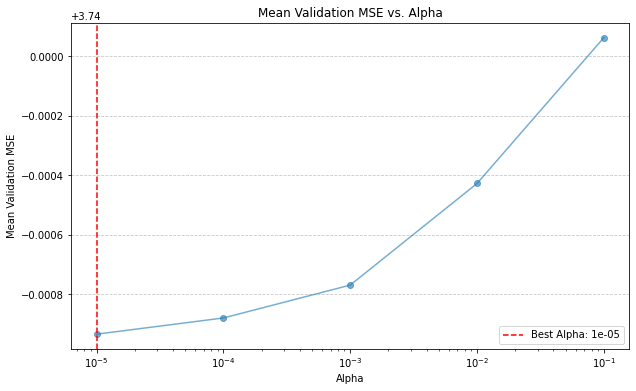

In [59]:
# Creating a plot for mean validation MSE values vs. alpha
plt.figure(figsize=(10, 6))
plt.plot(lasso.alphas_, lassoCV_val_mses_mean, marker='o', linestyle='-', alpha=0.6)
plt.xlabel('Alpha')
plt.ylabel('Mean Validation MSE')
plt.title('Mean Validation MSE vs. Alpha')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xscale('log')  # logarithmic scale for alpha values
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha}')
plt.legend()
plt.show()

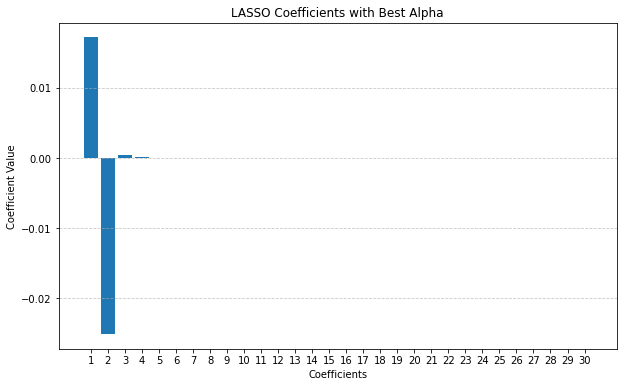

In [60]:
# Creating a plot for the coefficients of the LASSO model using the best alpha
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(lasso.coef_)+1), lasso.coef_)
plt.xlabel('Coefficients')
plt.ylabel('Coefficient Value')
plt.title('LASSO Coefficients with Best Alpha')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(1, len(lasso.coef_)+1))

plt.show()

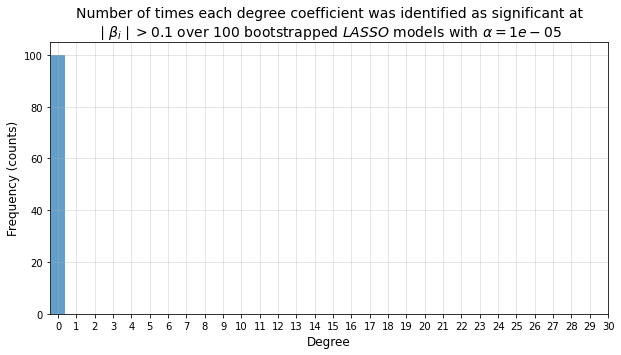

In [61]:
include_bias=False
fit_intercept=True

# Setting bootstrapping parameters
numboot = 100
max_degree = 30

significant_degrees = {}

X_train_no_df = pd.DataFrame(X_train_no, columns=['Price'])
y_train_no_df = pd.DataFrame(y_train_no, columns=['Quantity'])  
df_train_no = pd.concat([X_train_no_df, y_train_no_df], axis=1)

# Performing bootstraps
for i in range(numboot):
    df_boot = df_train_no.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Price"]]
    x_poly_train_boot = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Quantity

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=5_000,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train_boot, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

NOTE: These results are trivial, therefore we did not proceed further with training a regularized model.

    DECISION TREE REGRESSION MODEL TUNING

Further improvements on our baseline decision tree regression model, which had a test MSE of 3.7269 and test R-squared score of 0.1081, are implemented through GridSearch cross-validation, AdaBoost, and other model creation.

- GridSearch cross-validation: We perform cross-validation using GridSearchCV. This returns an optimal tree depth of 8 -- for a model of this depth, the test MSE is 3.7269 and the R-squared score is 0.1081. This is the same as our baseline decision tree regression model, indicating that there is a plateau in performance beyond a certain tree depth.

- single overfit (depth-60) tree: We fit a single overfit tree model to examine whether bagging techniques are appropriate. This model yields the same train and test MSEs as our depth-8 tree, confirming that we have already previously reached the limit on performance improvement. Since these MSE values are no different from those of our best depth tree, the tree is not quite overfitting as we had hoped for bagging. We thus choose to try tuning via boosting instead. 

- single stump (depth-1): We fit a single underfit tree model, or stump, to examine whether boosting techniques are appropriate. This model yields a train MSE of 3.8005 and test MSE of 3.8141, which are both higher than the respective MSE scores for our previous models. We thus proceed with our boosting methods using AdaBoost.

- AdaBoost model: We implement AdaBoost and try to find the best base learner model depth and iteration combination. We ultimately select a base learner of depth 4 with 10 iterations, and we fit our ensemble model using these parameters.

In a final comparison of these four models, we first note that our decision tree regression models perform consistently better than our polynomial regression models, which is why we select our best model for Objective 1 from the decision tree models. The depth-8 and depth-60 trees both have nearly identical performance accuracies (better accuracy scores than the single stump and AdaBoost models). The depth-8 tree is less computationally expensive, however, so we select it as our best model.

These results were a bit unexpected, since we would usually expect an ensemble model like boosting to improve performance by reducing bias while maintaining low variance. These unusual results are likely because of the fact that we are only dealing with one predictor here, but we wanted to proceed as we would with multiple predictors within the scope of this course to create a more thorough analysis.

GRID-SEARCH CROSS-VALIDATION

In [62]:
# Finding an optimal depth for a single decision tree using GridSearchCV
poly = PolynomialFeatures(degree=best_degree, interaction_only=False, include_bias=False)
X_poly_train = poly.fit_transform(X_train_no)
X_poly_test = poly.transform(X_test_no)

tree_reg = DecisionTreeRegressor(random_state=42)

dt = GridSearchCV(estimator=tree_reg, 
                            param_grid={'min_samples_split': range(2,30), 'max_depth': range(1, 30)}, 
                            scoring='neg_mean_squared_error', 
                            cv=5)

dt.fit(X_poly_train, y_train_no)
best_depth, best_min_sample_split = dt.best_params_['max_depth'], dt.best_params_['min_samples_split']


dt_tuned = DecisionTreeRegressor(max_depth=best_depth, 
                                 min_samples_split=best_min_sample_split, 
                                 random_state=42).fit(X_poly_train, y_train_no)

y_pred_train_tree = dt_tuned.predict(X_poly_train)
y_pred_test_tree = dt_tuned.predict(X_poly_test)

# Computing the mean squared errors
train_mse_tree = mean_squared_error(y_train_no, y_pred_train_tree)
test_mse_tree = mean_squared_error(y_test_no, y_pred_test_tree)

# Computing the R-squared of the model
tree_train_r2 = r2_score(y_train_no, y_pred_train_tree)
tree_test_r2 = r2_score(y_test_no, y_pred_test_tree)

# Computing train and test accuracies
tree_train_acc = dt_tuned.score(X_poly_train, y_train_no)
tree_test_acc = dt_tuned.score(X_poly_test, y_test_no)

In [63]:
print(f"Best depth found via GridSearchCV: {best_depth}")

print("Decision tree regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_tree,
        test_mse_tree,
    )
)

print(f"\tTest R-squared\t{tree_test_r2:.4f}")

Best depth found via GridSearchCV: 8
Decision tree regression model results:

	Train MSE	3.7123
	Test MSE	3.7269

	Test R-squared	0.1081


SINGLE OVERFIT TREE

In [64]:
# Fitting a single overfit tree to potentially be used for bagging / random forest
single_overfit_tree = DecisionTreeRegressor(max_depth=60, random_state=42)
single_overfit_tree.fit(X_poly_train, y_train_no)

y_pred_train_single_overfit = single_overfit_tree.predict(X_poly_train)
y_pred_test_single_overfit = single_overfit_tree.predict(X_poly_test)

train_mse_single_overfit = mean_squared_error(y_train_no, y_pred_train_single_overfit)
test_mse_single_overfit = mean_squared_error(y_test_no, y_pred_test_single_overfit)

single_overfit_train_acc = single_overfit_tree.score(X_poly_train, y_train_no)
single_overfit_test_acc = single_overfit_tree.score(X_poly_test, y_test_no)

print("Overfit decision tree regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_single_overfit,
        test_mse_single_overfit,
    )
)

Overfit decision tree regression model results:

	Train MSE	3.7123
	Test MSE	3.7269



SINGLE UNDERFIT TREE (STUMP)

In [65]:
# Fitting a single stump to be used for boosting
single_stump = DecisionTreeRegressor(max_depth=1, random_state=42)
single_stump.fit(X_poly_train, y_train_no)

y_pred_train_single_stump = single_stump.predict(X_poly_train)
y_pred_test_single_stump = single_stump.predict(X_poly_test)

train_mse_single_stump = mean_squared_error(y_train_no, y_pred_train_single_stump)
test_mse_single_stump = mean_squared_error(y_test_no, y_pred_test_single_stump)

single_stump_train_acc = single_stump.score(X_poly_train, y_train_no)
single_stump_test_acc = single_stump.score(X_poly_test, y_test_no)

print("Underfit decision tree regression model results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_single_stump,
        test_mse_single_stump,
    )
)

Underfit decision tree regression model results:

	Train MSE	3.8005
	Test MSE	3.8141



BOOSTING ENSEMBLE MODEL: ADABOOST

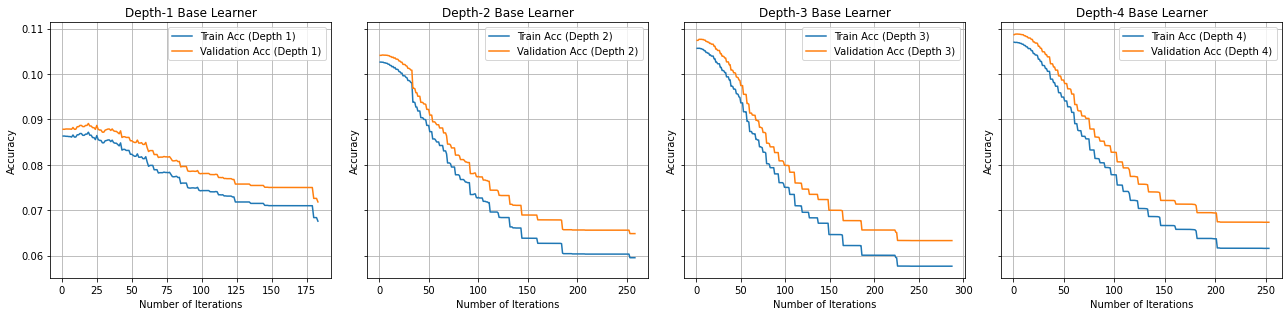

In [67]:
depths = [1, 2, 3, 4]
train_accuracies = []
val_accuracies = []

X_poly_train80 = poly.fit_transform(X_train80)
X_poly_val = poly.transform(X_val)

fig, axs = plt.subplots(1, len(depths), sharey=True, figsize=(18, 4.5))

for i in range(4):
    # Initializing AdaBoostClassifier with different base learner depths
    ada_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=i+1, random_state=42),
                                   learning_rate=0.05, n_estimators=800, random_state=42)
    
    # Fiting the AdaBoost model
    ada_boost.fit(X_poly_train80, y_train80)
    
    # Computing staged accuracies
    train_accuracy = list(ada_boost.staged_score(X_poly_train80, y_train80))
    val_accuracy = list(ada_boost.staged_score(X_poly_val, y_val))
    
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Plotting the effect of the number of iterations on train and validation accuracy
    iterations = range(1, len(train_accuracy) + 1)
    axs[i].plot(iterations, train_accuracy, label=f'Train Acc (Depth {i+1})')
    axs[i].plot(iterations, val_accuracy, label=f'Validation Acc (Depth {i+1})')
    axs[i].set_xlabel('Number of Iterations')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Depth-{i+1} Base Learner')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

NOTE: We choose a combination of depth 4 and 10 iterations because this appears to be an approximate peak in validation accuracies across the graphs.

In [68]:
ada_boost_final = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4, random_state=42),
                               learning_rate=0.05, n_estimators=10, random_state=0)
ada_boost_final.fit(X_poly_train, y_train_no)

ada_train_acc = ada_boost_final.score(X_poly_train, y_train_no)
ada_test_acc = ada_boost_final.score(X_poly_test, y_test_no)

In [69]:
results = {
    'classifier': [
        'single depth-8 tree chosen by CV',
        'single overfit depth-60 tree',
        'single underfit stump',
        'AdaBoost depth-2 trees, 10 iterations'
    ],
    'training accuracy': [
        tree_train_acc,
        single_overfit_train_acc,
        single_stump_train_acc,
        ada_train_acc
    ],
    'test accuracy': [
        tree_test_acc,
        single_overfit_test_acc,
        single_stump_test_acc,
        ada_test_acc
    ]
}

results_df = pd.DataFrame(results)
results_df

,classifier,training accuracy,test accuracy
0,single depth-8 tree chosen by CV,0.107866,0.108144
1,single overfit depth-60 tree,0.107866,0.108145
2,single underfit stump,0.086653,0.087285
3,"AdaBoost depth-2 trees, 10 iterations",0.106823,0.107214


MODELING FOR OBJECTIVE 2: PREDICTING ANNUAL SALES CYCLES

In this section, we perform more in-depth time series analysis and construct baseline models using ARIMA. For ease of use, we created two new DataFrames for Revenue and Quantity indexed by InvoiceDate. Note that for our time series analysis here, we have chosen to use daily revenue and quantity data for more granularity in trend analysis. 

<u> Time Series Analysis </u>: We perform a number of tests and analyses for our time series.

- Augmented Dickey-Fuller Tests: The ADF tests for the Revenue and Quantity time series check for stationarity in the time series. Since the p-values for both time series are less than the critical value of 0.05, we reject the null hypothesis of non-stationarity for both time series. This means that our assumption of stationarity holds for both the Revenue and Quantity time series -- we can thus move ahead with modeling without having to transform our series. Qualitatively, we can see this in our time series graphs, which do not exhibit obvious trends (though there is seasonality). 

- Additive Decomposition: Additive decomposition of the revenue time series is displayed below (note that revenue is more important for forecasting sales and profit overall, which is why we have chosen to mainly focus on our revenue trends in this section). The trend, seasonal, and residual components of our time series are shown. There is no strong long-term trend, though there appears to be strong seasonality in our data, as expected. The residuals appear to be quite random, which is good.

- Autocorrelation / Partial Autocorrelation: Autocorrelation and partial autocorrelation plots for the Revenue and Quantity time series are used to examine the correlation between each series' values at a given point in time and past values. The ACF plots show that, with 95% probability, lags up until approximately the mid-twenties appear to be somewhat significant for revenue, while only a few lags are considered significant for quantity sold (significant lags correspond to bars outside of the blue cone in each plot). Overall, the ACF plots appear to indicate a much stronger correlation between past and "current" values for revenue compared to quantity; this implies that we can use present values to better predict future values for revenue than for quantity. The PACF plots affirm a stronger partial correlation of the Revenue time series with its own lagged values, regressed the values of the time series at all shorter lags. However, the difference in partial correlation between the two time series does not appear to be as strong.

- Granger Causality Tests: The Granger Causality Tests between Quantity and Revenue with 2 lags yield p-values below the critical value of 0.05, indicating that the Quantity time series can be used to (at least somewhat) predict the Revenue time series with a 2-day lag. The tests with 1 and 3 lags did not yield this relationship. Since the Granger Causality Tests indicated a relationship between the Quantity and Revenue time series with 2 lags, we implemented the baseline time series ARIMA modeling with just our revenue data for simplicity, assuming a similar trend in quantity (with a 2-day lag effect).


In [70]:
# Creating a new DataFrame with 'Revenue' indexed by 'InvoiceDate'
revenue_df = df.groupby(df['InvoiceDate'].dt.date)['Revenue'].sum().reset_index(name='Revenue')
revenue_df.set_index('InvoiceDate', inplace=True) 

# Creating a new DataFrame with 'Quantity' indexed by 'InvoiceDate'
quantity_df = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index(name='Quantity')
quantity_df.set_index('InvoiceDate', inplace=True) 

display(revenue_df.head())
display(quantity_df.head())

,Revenue
InvoiceDate,
2009-12-01,53173.03
2009-12-02,62763.59
2009-12-03,68093.05
2009-12-04,40346.40
2009-12-05,9803.05


,Quantity
InvoiceDate,
2009-12-01,24022
2009-12-02,29942
2009-12-03,44896
2009-12-04,21001
2009-12-05,5033


    AUGMENTED DICKEY-FULLER TESTS

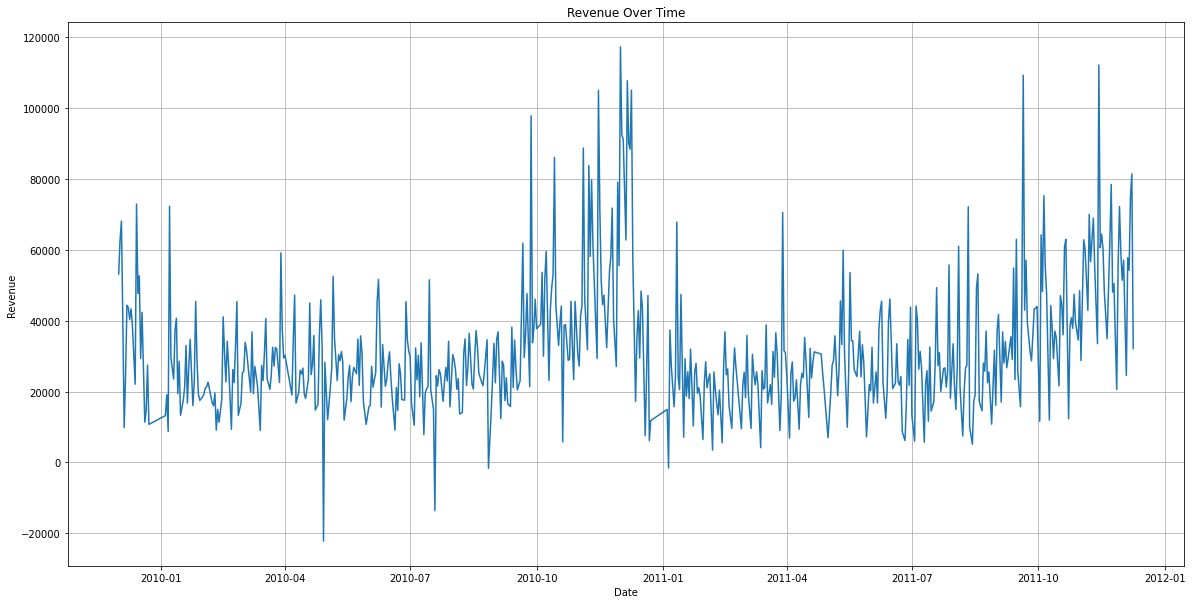

Augmented Dickey-Fuller Test:
ADF Statistic: -2.9000884733110204
p-value: 0.04533771019719508
Critical Values:
	1%: -3.441444394224128
	5%: -2.8664345376276454
	10%: -2.569376663737217


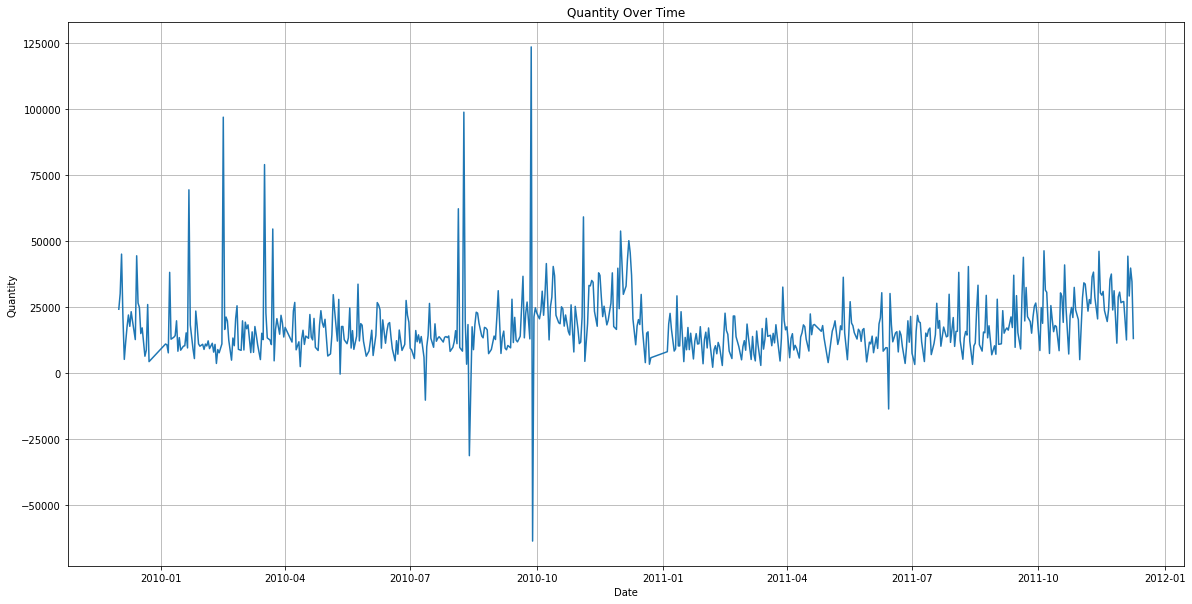

Augmented Dickey-Fuller Test:
ADF Statistic: -3.670468987778323
p-value: 0.0045482386012916515
Critical Values:
	1%: -3.441444394224128
	5%: -2.8664345376276454
	10%: -2.569376663737217


In [71]:
from statsmodels.tsa.stattools import adfuller

def adf_test_graph(df):
    # Plotting time series graph (daily data)
    plt.figure(figsize=(20, 10))
    plt.plot(df.index, df, label='Data')
    plt.title(df.columns[0] + ' Over Time')
    plt.xlabel('Date')
    plt.ylabel(df.columns[0])
    plt.grid(True)
    plt.show()

    # Performing Augmented Dickey-Fuller test
    result = adfuller(df)
    print('Augmented Dickey-Fuller Test:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Plotting graphs and performing ADF tests for revenue and quantity
adf_test_graph(revenue_df)
adf_test_graph(quantity_df)

    ADDITIVE DECOMPOSITION

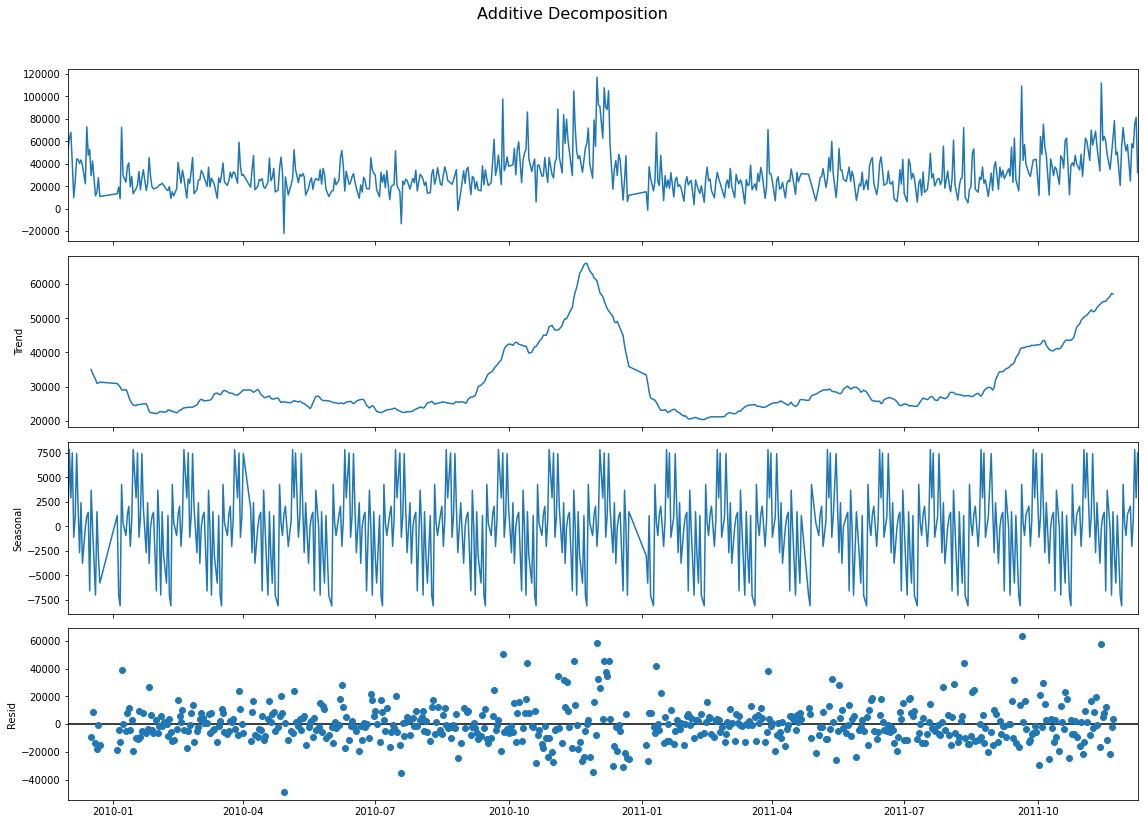

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive decomposition of revenue
additive_decomposition = seasonal_decompose(revenue_df, model='additive', period=30)
plt.rcParams.update({'figure.figsize': (16, 12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

    AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOTS

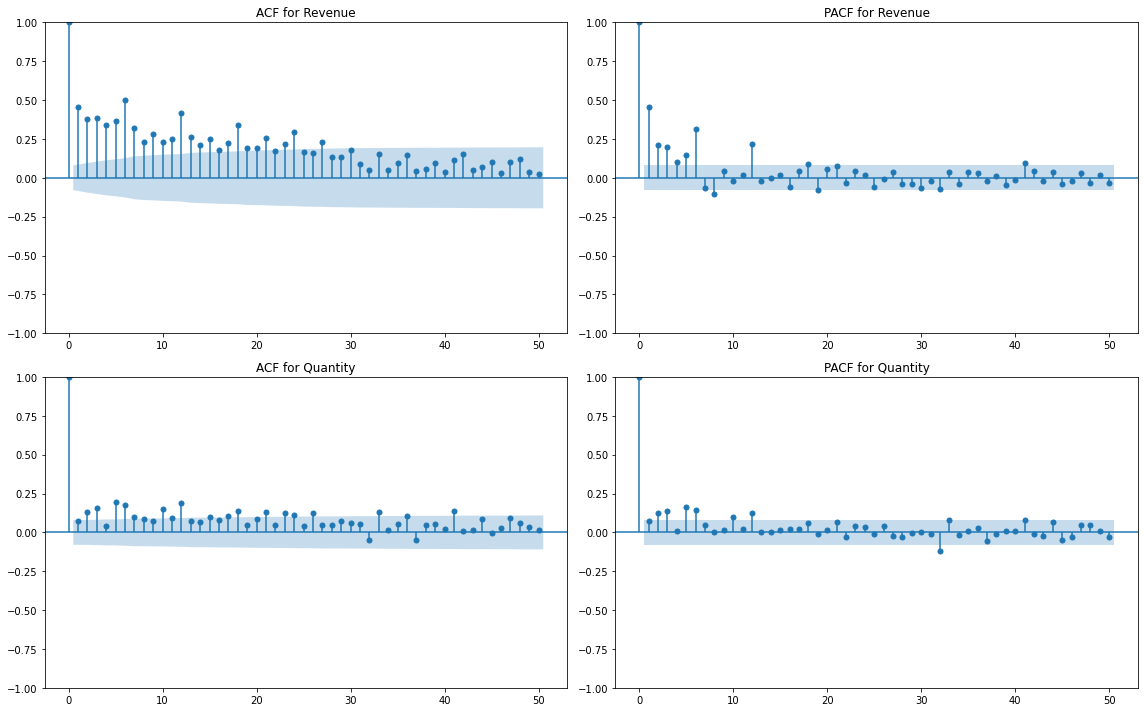

In [73]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drawing plot for Revenue
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_acf(revenue_df['Revenue'].tolist(), lags=50, ax=axes[0, 0], title='ACF for Revenue')
plot_pacf(revenue_df['Revenue'].tolist(), lags=50, ax=axes[0, 1], title='PACF for Revenue')

# Drawing plot for Quantity
plot_acf(quantity_df['Quantity'].tolist(), lags=50, ax=axes[1, 0], title='ACF for Quantity')
plot_pacf(quantity_df['Quantity'].tolist(), lags=50, ax=axes[1, 1], title='PACF for Quantity')

plt.tight_layout()
plt.show()

    GRANGER CAUSALITY TESTS

In [74]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 3
data = pd.concat([revenue_df['Revenue'], quantity_df['Quantity']], axis=1)
results = grangercausalitytests(data, max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0188  , p=0.8911  , df_denom=600, df_num=1
ssr based chi2 test:   chi2=0.0189  , p=0.8908  , df=1
likelihood ratio test: chi2=0.0189  , p=0.8908  , df=1
parameter F test:         F=0.0188  , p=0.8911  , df_denom=600, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4243  , p=0.0332  , df_denom=597, df_num=2
ssr based chi2 test:   chi2=6.9059  , p=0.0317  , df=2
likelihood ratio test: chi2=6.8666  , p=0.0323  , df=2
parameter F test:         F=3.4243  , p=0.0332  , df_denom=597, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2719  , p=0.2831  , df_denom=594, df_num=3
ssr based chi2 test:   chi2=3.8608  , p=0.2769  , df=3
likelihood ratio test: chi2=3.8485  , p=0.2783  , df=3
parameter F test:         F=1.2719  , p=0.2831  , df_denom=594, df_num=3


<u> Time Series Models </u>: We implement three basic time series models for our Revenue time series, measuring performance by the RSS metric. 

- AutoRegressive Model (AR): The AR model, which assumes that past values have a linear effect on current values, yielded an RSS score of ~118,130,418,450.

- Moving Average Model (MA): The MA model, which assumes that the current value is the series mean plus a linear combination of errors from previous predicted values, yielded an RSS score of ~125,701,008,907.

- ARMA/ARIMA Model: The ARMA/ARIMA model essentially integrates the AR and MA models. It yielded an RSS score of ~114,601,010,882.

We can see that the ARMA/ARIMA model has the lowest RSS score. We thus continue tuning this model by testing various combinations of parameters.

/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


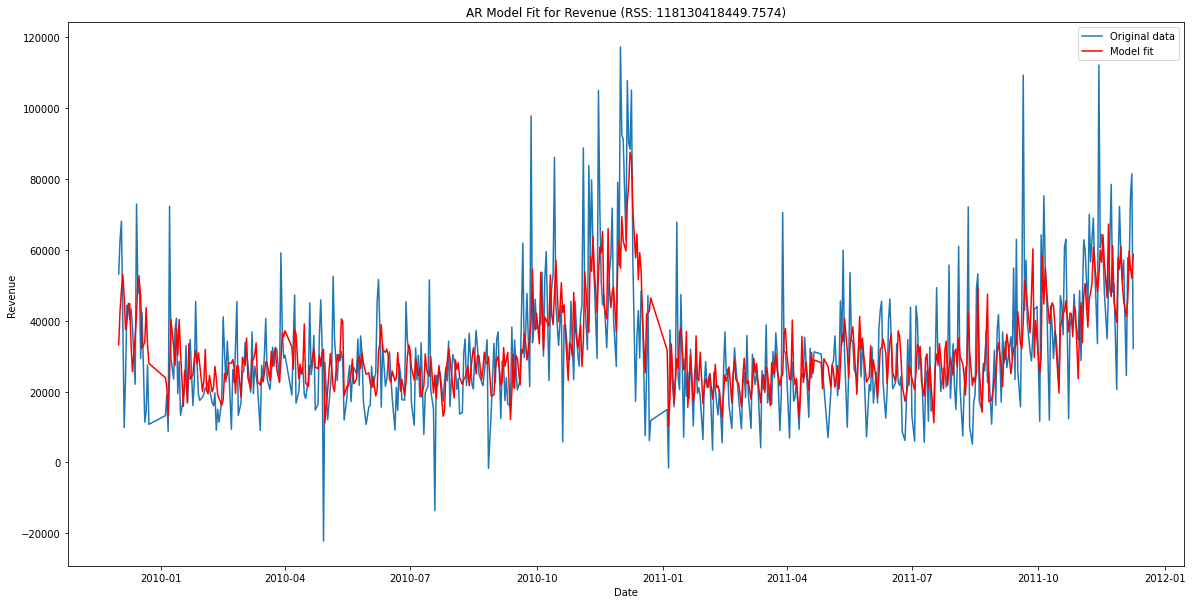

In [75]:
import pmdarima as pm

# Fitting AutoRegressive model for revenue
rev_time_model = pm.ARIMA(order=(12, 0, 0))
results_rev_ARMA = rev_time_model.fit(revenue_df)
fitted_values = results_rev_ARMA.predict_in_sample()

# Plotting the original data and the fitted values
plt.figure(figsize=(20, 10))
plt.plot(revenue_df.index, revenue_df, label='Original data')
plt.plot(revenue_df.index, fitted_values, color='red', label='Model fit')
rss = sum((fitted_values - revenue_df.squeeze())**2) 
plt.title(f'AR Model Fit for Revenue (RSS: {rss:.4f})')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


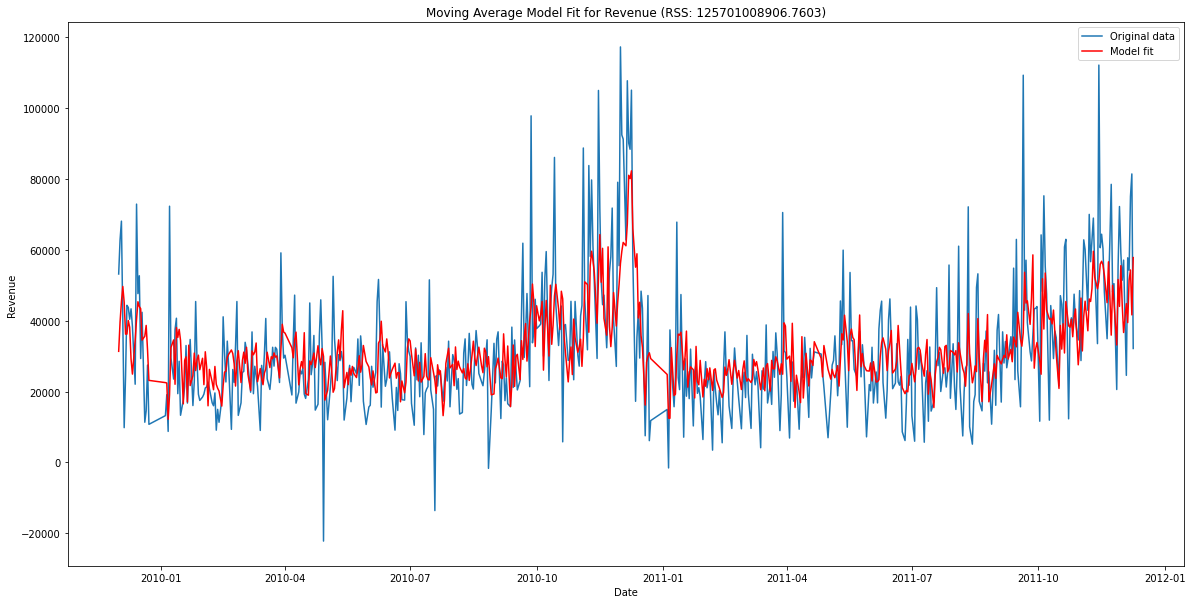

In [76]:
# Fitting Moving Average model for revenue
rev_time_model = pm.ARIMA(order=(0, 0, 12))
results_rev_ARMA = rev_time_model.fit(revenue_df)
fitted_values = results_rev_ARMA.predict_in_sample()

# Plotting the original data and the fitted values
plt.figure(figsize=(20, 10))
plt.plot(revenue_df.index, revenue_df, label='Original data')
plt.plot(revenue_df.index, fitted_values, color='red', label='Model fit')
rss = sum((fitted_values - revenue_df.squeeze())**2)
plt.title(f'Moving Average Model Fit for Revenue (RSS: {rss:.4f})')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


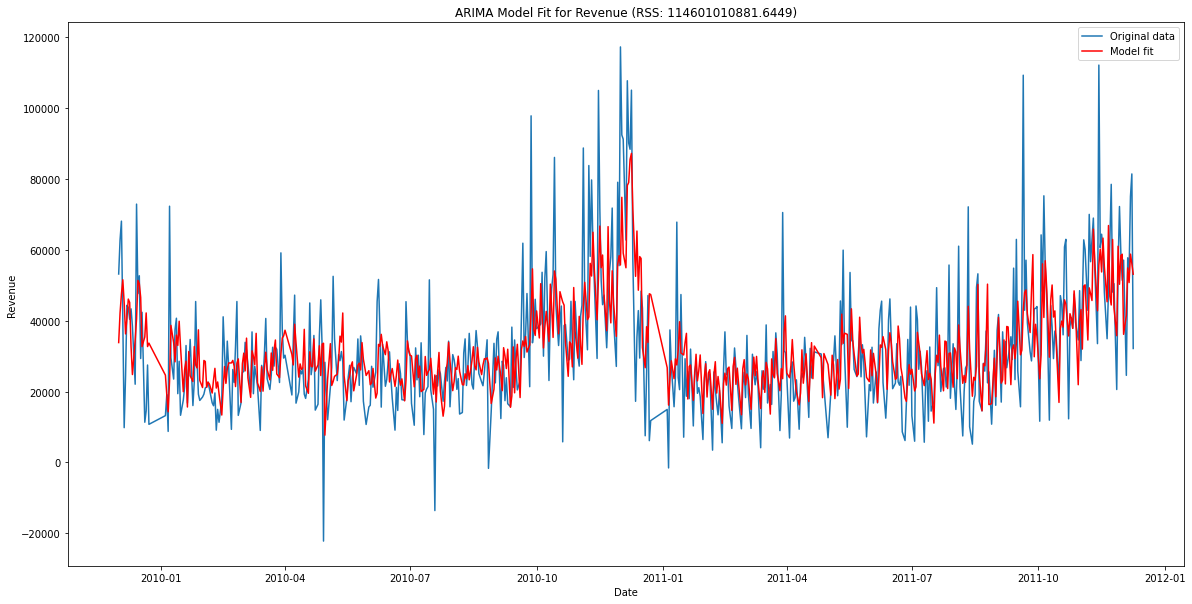

In [77]:
# Fitting ARIMA model for revenue
rev_time_model = pm.ARIMA(order=(12, 0, 12))
results_rev_ARMA = rev_time_model.fit(revenue_df)
fitted_values = results_rev_ARMA.predict_in_sample()

# Plotting the original data and the fitted values
plt.figure(figsize=(20, 10))
plt.plot(revenue_df.index, revenue_df, label='Original data')
plt.plot(revenue_df.index, fitted_values, color='red', label='Model fit')
rss = sum((fitted_values - revenue_df.squeeze())**2)
plt.title(f'ARIMA Model Fit for Revenue (RSS: {rss:.4f})')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

    FORECASTING

We perform preliminary forecasting of the Revenue time series by simulating from our ARIMA model, with model parameters fitted to in-sample data. The results of this forecasting are displayed below. Note that we tested various combinations of hyperparameters, and found that (12, 0, 12) yielded the lowest RSS score by trial and error.

/Users/joyceshi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


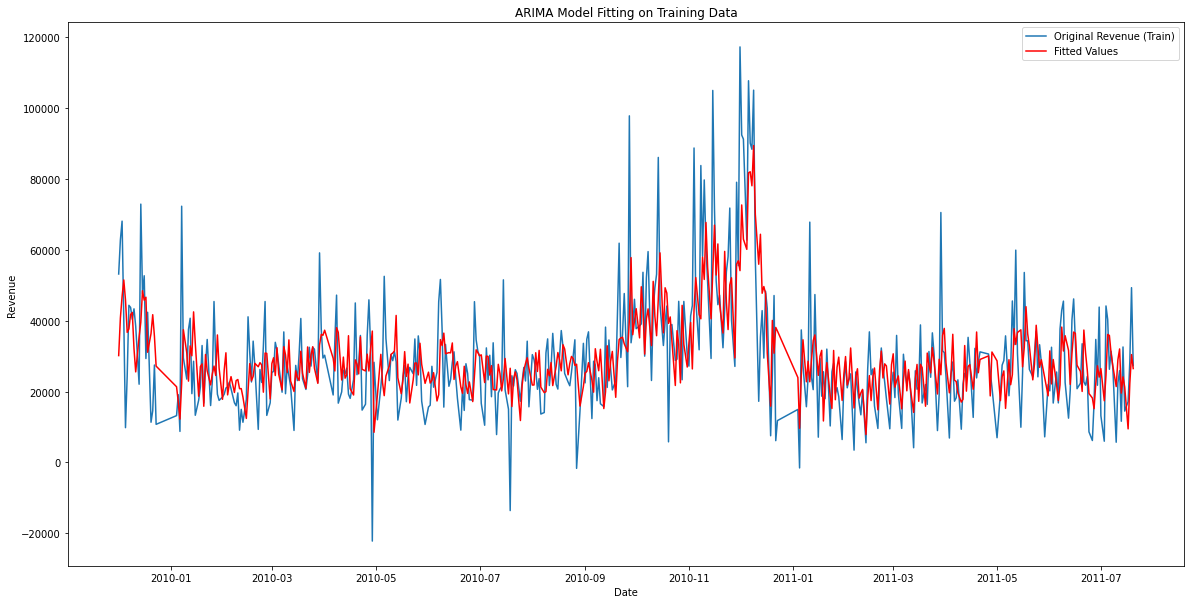

In [78]:
# Forecasting
from pmdarima.model_selection import train_test_split

# Splitting the data into training and testing sets
rev_train, rev_test = train_test_split(revenue_df, test_size=0.2)
rev_train_values = rev_train.values

rev_fc_model = pm.ARIMA(order=(12, 0, 12))
rev_fc_model.fit(rev_train_values)

fitted_values = rev_fc_model.fittedvalues()

plt.figure(figsize=(20, 10))
plt.plot(rev_train.index, rev_train_values, label='Original Revenue (Train)')
plt.plot(rev_train.index, fitted_values, color='red', label='Fitted Values')

plt.title('ARIMA Model Fitting on Training Data')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


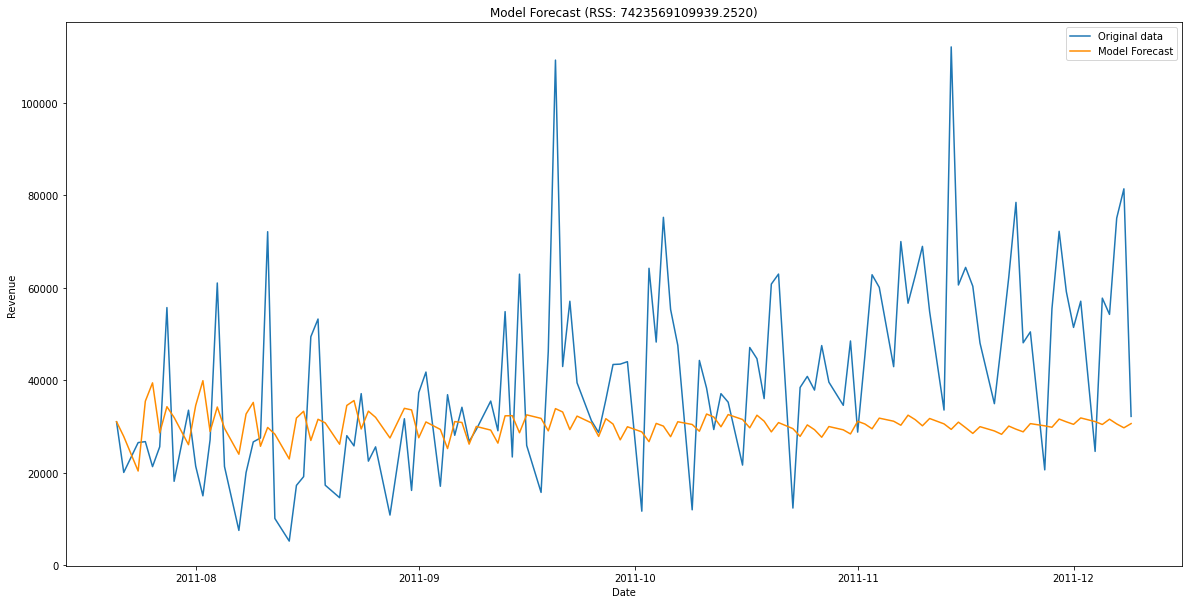

In [79]:
# Generating forecasts
forecast = rev_fc_model.predict(n_periods=len(rev_test))

# Plotting the test data and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(rev_test.index, rev_test, label='Original data')
plt.plot(rev_test.index, forecast, color='darkorange', label='Model Forecast')

# Calculating and displaying the RSS (Residual Sum of Squares)
rss = np.sum((rev_test.values - forecast)**2)
plt.title(f'Model Forecast (RSS: {rss:.4f})')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

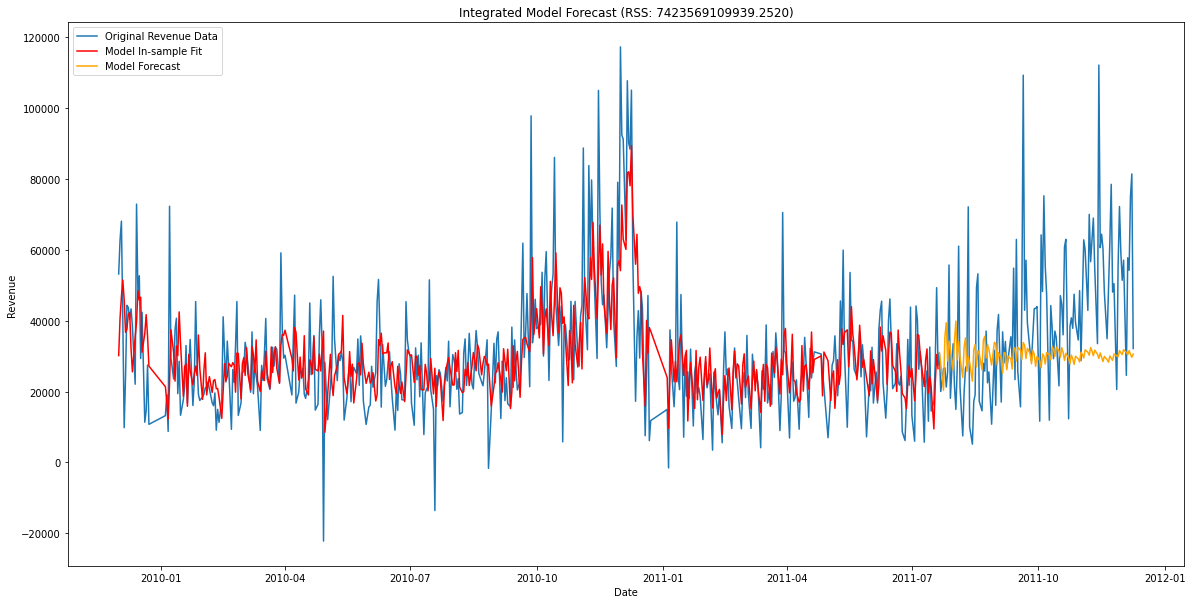

In [80]:
# Plotting the fitted and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(revenue_df.index, revenue_df, label='Original Revenue Data')
plt.plot(rev_train.index, fitted_values, color='red', label='Model In-sample Fit')

plt.plot(rev_test.index, forecast, color='orange', label='Model Forecast')

# Calculating and displaying the RSS (Residual Sum of Squares) for the forecast
rss = np.sum((rev_test.values - forecast)**2)
plt.title(f'Integrated Model Forecast (RSS: {rss:.4f})')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

# 5. RESULTS & DISCUSSION

Overall, we have found that we can weakly predict the quantity sold of an item based on its price, and we can roughly predict annual sales cycles using time series analysis. However, even our tuned models have relatively low accuracy scores / high RSS scores, indicating that it is hard to accurately achieve both of our objectives. Inconsistent/non-continuous pricing data makes modeling for Objective 1 more difficult, though pricing and quantity data are roughly consistent with standard economic theory (the higher the price, the lower the maximum demand). Sales volatility also makes sales trend modeling beyond general trends difficult, though we can still encapsulate overall patterns.

In future work, broadening the scope of the modeling done here would be interesting. For instance, extending/generalizing this analysis to other retailers (perhaps in different countries or industries) would help us analyze whether the customer behavior observed here also holds across different retailers, which is important in forming more general sales forecasting techniques for the retail industry. We would also recommend examining the relationship between revenue of an item and other characteristics of that item (if this data is available in other datasets). Another possible direction for further work would be adding more complexity to our time series analysis (perhaps by analyzing aesthetic trends in item sales as well, rather than just seasonal trends) and modeling how macroeconomic situations (such as recessions) affect our results.